Changes from v2

- implemented the possiblity to add nodes to the system
- add new visualization based data frame

**Importing Dependencies**

In [1]:
# Imports
# Gymnasium imports
import gymnasium as gym 
from gymnasium import Env
from gymnasium.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete 

import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

# Import helpers
import numpy as np
import pandas as pd
import random
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns

from collections import deque

# Import stable baselines
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy

from Environment.env_v5 import *
from Functions.visualization_functions import *

**Configuration of the Scenario**

In [2]:
# Configuration of the network
with open('./Config/network_config_v0.json') as file:
    network_config = file.read()

# TODO : Implement configuaration for cost and demand (actual and exptected)

**Building the environment**

In [3]:
EP_LENGTH = 30 # Length of the episode

env = SS_Mngmt_Env(network_config=network_config,
                   EP_LENGTH=EP_LENGTH,
                   render_mode="human")

Node Attributes:
Node A: {'type': 'manufacturer', 'I': 30}
Node B: {'type': 'manufacturer', 'I': 28}
Node C: {'type': 'manufacturer', 'I': 32}
Node D: {'type': 'distributor'}
Node S: {'type': 'source'}


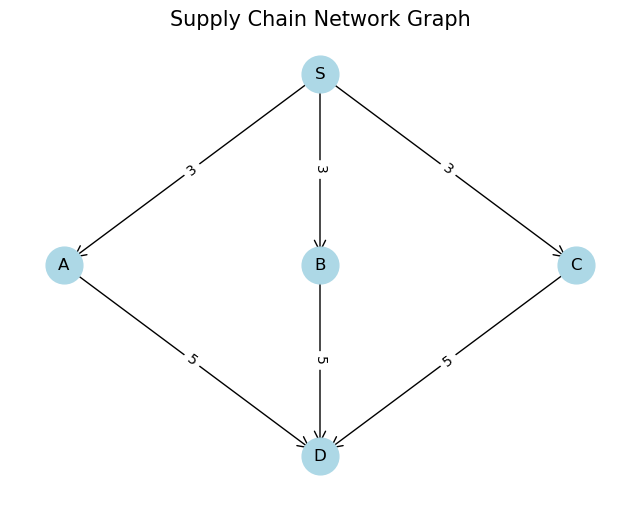

In [4]:
env.render_network()

In [5]:
from stable_baselines3.common.env_checker import check_env

check_env(env, warn=True)

**Testng the environment**

In [6]:
env = SS_Mngmt_Env(network_config=network_config,
                   EP_LENGTH=EP_LENGTH,
                   render_mode="human")

episodes = 1
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        action = env.action_space.sample()
        n_state, reward, done, info, _ = env.step(action)
        score += reward

        env.render()

# 30, 28, 32

Episode Length: 1
Stock Level: [18.6 17.4 32. ]
Planned Demand: [13.2 13.5  0. ]
Actual Demand: [11.4 10.6  0. ]
Action: [41.7  8.5 30. ]
Order: [0 0 0]
Reward: -772.2715230349329

Episode Length: 2
Stock Level: [ 9.4 12.4 32. ]
Planned Demand: [7.8 5.8 0. ]
Actual Demand: [9.2 5.1 0. ]
Action: [47.7 45.1 28.3]
Order: [0 0 0]
Reward: -1572.370996902325

Episode Length: 3
Stock Level: [ 9.4 12.4 20.9]
Planned Demand: [ 0.   0.  11.5]
Actual Demand: [ 0.   0.  11.1]
Action: [26.7  1.5 30.7]
Order: [0 0 0]
Reward: -2294.1006581906754

Episode Length: 4
Stock Level: [42.3 17.4 45.8]
Planned Demand: [9.4 3.  8.4]
Actual Demand: [8.8 3.5 5. ]
Action: [22.7 24.2 34.5]
Order: [41.7  8.5 30. ]
Reward: -3151.7223914419815

Episode Length: 5
Stock Level: [90.  48.3 74.2]
Planned Demand: [ 0.  14.6  0. ]
Actual Demand: [ 0.  14.2  0. ]
Action: [21.2 29.6 46.3]
Order: [47.7 45.1 28.3]
Reward: -4245.132213040045

Episode Length: 6
Stock Level: [101.8  49.7 104.8]
Planned Demand: [14.1  0.   0. ]
Act

Episode Length: 30
Stock Level: [601.5 608.6 667.5]
Planned Demand: [ 0.   0.  13.2]
Actual Demand: [ 0.   0.  11.8]
Action: [20.1 24.  39.3]
Order: [16.4 10.7 42.5]
Reward: -71619.72655883113



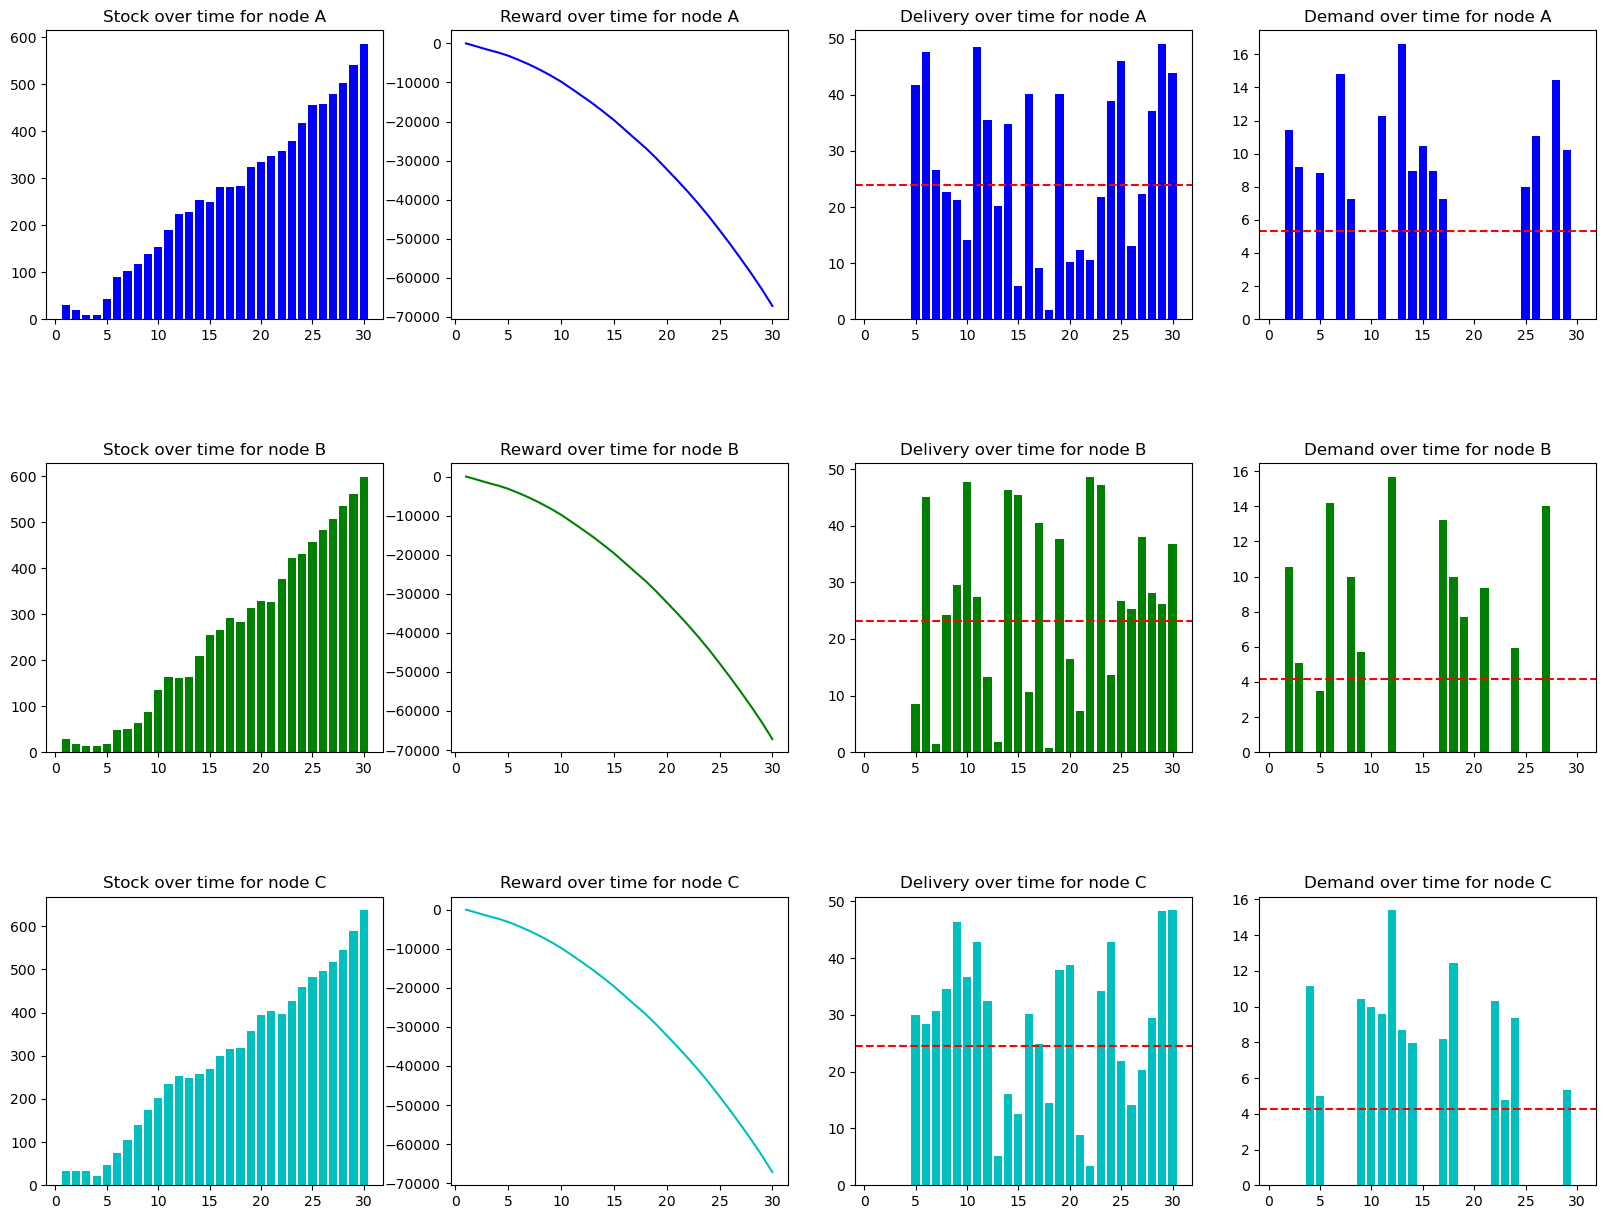

In [7]:
df = pd.read_csv('./Data/2024-10-15_13_last_environment_data.csv')
plot_data(df)

**Train Model**


In [8]:
log_path = os.path.join('Training', 'Logs')
model_path = os.path.join('Training', 'Models', 'PPO')
# model_path = os.path.join('Training', 'Models', 'A2C')

In [9]:
env = SS_Mngmt_Env(network_config=network_config,
                   EP_LENGTH=EP_LENGTH,
                   render_mode="human")

def make_env():
    # Create a new environment here
    env = SS_Mngmt_Env(network_config=network_config, EP_LENGTH=EP_LENGTH, render_mode="human")
    return env

num_envs = 8

dummy_env = DummyVecEnv([lambda: env])
# vec_env = make_vec_env(make_env, n_envs=num_envs)

model = PPO("MlpPolicy", 
            dummy_env,
            learning_rate = 0.0007,
            gamma = 0.99,
            verbose=1,
            tensorboard_log=log_path)

# model = A2C("MlpPolicy",
#             vec_env,
#             learning_rate = 0.0005,
#             gamma = 0.99,
#             verbose=1,
#             tensorboard_log=log_path)

Using cpu device


In [10]:
model.learn(total_timesteps=10000)

Logging to Training/Logs/PPO_57
-----------------------------
| time/              |      |
|    fps             | 6231 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 3345          |
|    iterations           | 2             |
|    time_elapsed         | 1             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 1.7189304e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.26         |
|    explained_variance   | 3.58e-07      |
|    learning_rate        | 0.0007        |
|    loss                 | 4.58e+10      |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.000114     |
|    std                  | 1             |
|    value

In [14]:
model.save(model_path)
model.load(model_path)

# evaluate_policy(model, vec_env, n_eval_episodes=10, render=True, return_episode_rewards=True)
evaluate_policy(model, dummy_env, n_eval_episodes=1, render=True, return_episode_rewards=True)

Episode Length: 1
Stock Level: [30.  19.7 11.9]
Planned Demand: [ 0.   8.4 16.9]
Actual Demand: [ 0.   8.3 20.1]
Action: [24.9 24.9 24.7]
Order: [0 0 0]
Reward: -740.8918756123101

Episode Length: 2
Stock Level: [24.6 19.7  4.5]
Planned Demand: [8.6 0.  7.1]
Actual Demand: [5.4 0.  7.4]
Action: [24.9 24.9 24.7]
Order: [0 0 0]
Reward: -1487.1492075898143

Episode Length: 3
Stock Level: [24.6 11.   4.5]
Planned Demand: [0.  9.1 0. ]
Actual Demand: [0.  8.7 0. ]
Action: [24.9 24.9 24.8]
Order: [0 0 0]
Reward: -2224.254463501029

Episode Length: 4
Stock Level: [49.5 22.2 29.2]
Planned Demand: [ 0.  13.8  0. ]
Actual Demand: [ 0.  13.7  0. ]
Action: [24.9 24.9 24.7]
Order: [24.9 24.9 24.7]
Reward: -3073.1760252502986

Episode Length: 5
Stock Level: [74.4 47.1 53.9]
Planned Demand: [0. 0. 0.]
Actual Demand: [0. 0. 0.]
Action: [24.9 25.  24.7]
Order: [24.9 24.9 24.7]
Reward: -4098.635828425342

Episode Length: 6
Stock Level: [99.2 63.2 67.2]
Planned Demand: [0.  8.5 8.2]
Actual Demand: [ 0.  

/Users/jonasrenfer/miniconda3/envs/rl-scm/lib/python3.12/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


([-780391.0427246094], [30])

In [15]:
df = pd.read_csv('./Data/2024-10-15_13_last_environment_data.csv')

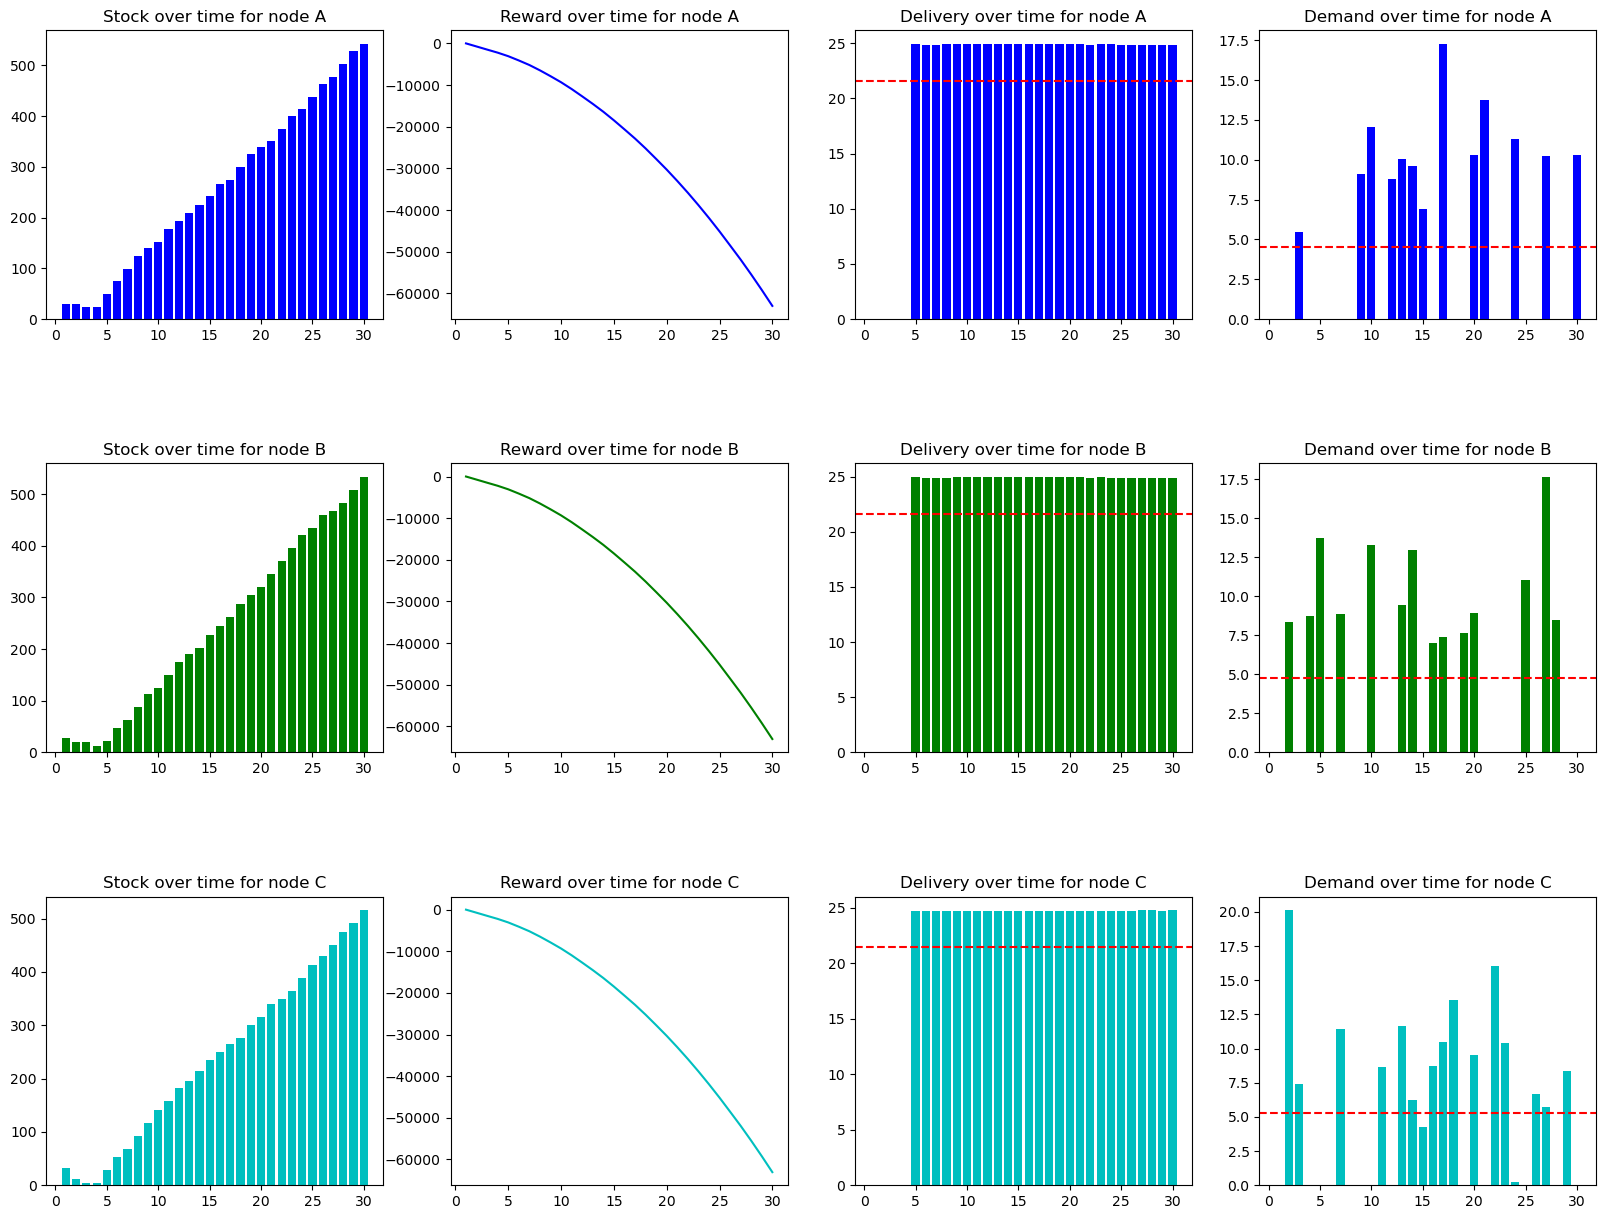

In [16]:
plot_data(df)